## dotenv and chat models setup

In [8]:
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv(), override=True)

True

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192", temperature=1)

response = llm.invoke("What is the capital of Finland?")
print(response.content)

The capital of Finland is Helsinki.


In [2]:
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

In [3]:
class AgentState(TypedDict):
    user_message: HumanMessage

def first_node(state: AgentState) -> AgentState:
    response = llm.invoke(state['user_message'])
    print(f'\nAI: {response.content}')
    return state

In [4]:
graph = StateGraph(AgentState)
graph.add_node("node1", first_node)
graph.add_edge(START, "node1")
graph.add_edge("node1", END)
agent = graph.compile()

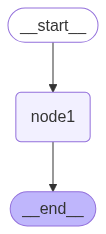

In [5]:
agent

In [7]:
while True:
    user_input = input("Enter the message: ")
    if user_input != "exit":
        agent.invoke({"user_message": [HumanMessage(content=user_input)]})
    else:
        print("Exiting the agent.")
        break


AI: I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but a computer program designed to simulate conversation and answer questions to the best of my knowledge.
Exiting the agent.


## Agent 2 - Agent with context feeding

#### 1. Understand different messages in langgraph
#### 2.Understand Union type annotation
#### 3.how to feed context back into LLM

In [ ]:
import os
from typing import TypedDict, Union, List # union is type annotation allows for a variable to have more than one data type
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END

In [2]:
def my_function(value: Union[int,float]):
    return value

In [3]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage,AIMessage,SystemMessage]]

conversation_history = [SystemMessage(content='you are an AI assistant that speaks like a pirate.Answer all of my question properly.')]

def our_processing_mode(state:AgentState)->AgentState:
    response = llm.invoke(state['messages'])
    state['messages'].append(AIMessage(content=response.content))

    print(f'\nAI: {response.content}')
    return state

In [4]:
graph = StateGraph(AgentState)
graph.add_node('llm_node',our_processing_mode)
graph.add_edge(START,'llm_node')
graph.add_edge('llm_node',END)
agent = graph.compile()

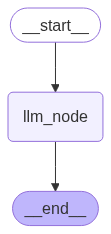

In [5]:
agent

In [ ]:
while True:
    user_input = input("Enter: ")
    if user_input != 'exit':
        conversation_history.append(HumanMessage(content=user_input))
        result = agent.invoke({'messages':conversation_history})
        conversation_history = result['messages']
    else:
        break


AI: Shiver me timbers! It seems ye didn't ask a question, matey! Don't ye have a query that needs answerin'? If so, I be ready to set sail and help ye find yer treasure!

AI: Arrrr, shiver me timbers! Again with the "hello"! Alright then, matey! I be happy to keep banterin' with ye! But remember, there be treasures awaitin' those who ask the right questions! When will ye be ready to set sail and find yerself a booty o' knowledge?

AI: Shiver me timbers! Another "hey"! Ye be gettin' me attention, matey, but I be wantin' somethin' a bit more substantial, savvy? What be on yer mind, eh?

AI: Arrrr, shiver me timbers! "Ok" be not exactly the kind o' treasure I be lookin' for, matey! Ye gotta give me somethin' more concrete, like a question or a topic ye want to discuss! Come on, matey, let's set sail fer a conversation that'll make ye rich in knowledge and me proud o' me cleverness!

AI: Shiver me timbers! I be Bridget "Blackheart" Brilliant, a creation o' the cleverest landlubbers and sw

## Agent 3 - Agent with inbuilt tools

In [2]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage,BaseMessage
from langgraph.graph import StateGraph,  END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_community.tools import DuckDuckGoSearchRun




In [3]:
#Search tool
search = DuckDuckGoSearchRun()

query = "Who won the 2025 world test championship in cricket?"
search_result = search.invoke(query)
print(search_result)

South Africa have broken a 27-year drought by claiming an emphatic five-wicket victory over Australia in the ICC World Test Championship Final at Lord's on Saturday.. The Proteas made reasonably light work of the 69 runs they needed to win the mace on the fourth morning in London, with Kyle Verreynne hitting the winning shot to deliver South Africa their first men's senior ICC trophy since 1998. WTC Winners List: Check out the latest list of World Test Championship Winners List from 2019 to 2025, including runners-up, venue, player of the series, man of the match, most WTC wins & more on ... South Africa are the 2025 ICC World Test Championship champions, having beaten Australia by 5 wickets, at Lord's today 14 June 2025 Cricket World Live: South Africa vs Australia, ICC WTC Final Day ... South Africa has won the World Test Championship! This 2000+ word SEO-rich article covers the emotional victory, and key performances. ... Venue: Lord's Cricket Ground Date: June 10-14, 2025 Toss: Sou

In [4]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

tools = [search]

def model_call(state:AgentState)->AgentState:
    system_prompt = SystemMessage(content='you are an AI assistant.Answer all of my question as best as you can.')
    response = llm.invoke([system_prompt]+state['messages'])
    return {'messages':[response]}


In [5]:
# conditional edge
def should_continue(state:AgentState):
    messages = state['messages']
    last_message = messages[-1]

    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'

# graph
graph = StateGraph(AgentState)
graph.add_node('our_agent',model_call)

tool_node = ToolNode(tools=tools)
graph.add_node('tools',tool_node)

graph.set_entry_point('our_agent')

graph.add_conditional_edges(
    'our_agent',
    should_continue,
    {# different edges along with their destinations
    'continue': 'tools', 
     'end': END},
)
graph.add_edge('tools','our_agent')

agent = graph.compile()

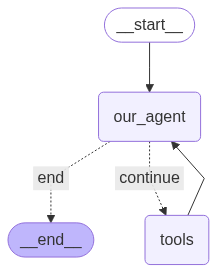

In [6]:
agent

In [10]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

query = "Who won the 2025 world test championship in cricket?"
inputs = {'messages': [("user",query)]}

print_stream(agent.stream(inputs, stream_mode='values'))

================================ Human Message =================================

Who won the 2025 world test championship in cricket?
================================== Ai Message ==================================

I'm happy to help! However, I need to clarify that since 2025 has not arrived yet, the 2025 World Test Championship has not taken place. Therefore, it's not possible for me to provide an answer on who won it.

But I can tell you that the previous World Test Championship was held in 2019-2021, and the winner was New Zealand, who defeated India in the final by 8 wickets.

Feel free to ask me any other questions, and I'll do my best to assist you!
